In [ ]:
# import the libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import Accuracy, F1Score, Precision, Recall
from keras.optimizers import SGD, Adam, Adagrad, RMSprop, Nadam, AdamW
from keras.src.losses import loss
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print(tf.__version__)

In [19]:
# adjustable parameters
TRAIN_DATA_DIR = r"C:\Users\Shahbaz\Desktop\dl\dataset\train"
VAL_DATA_DIR = r"C:\Users\Shahbaz\Desktop\dl\dataset\val"
MODEL_SAVE_DIR = r"C:\Users\Shahbaz\Desktop\dl\models"
LOG_DIR = r"C:\Users\Shahbaz\Desktop\dl\logs"

TESTING_MODE = False #####

IMG_SIZE = (224, 168)
NUM_CLASSES = 9
CHANNELS = 3

EPOCHS = 20
LEARNING_RATE = 1e-5
PATIENCE = 15
BATCH = 32
SEED = 42

MODEL_NAME = 'cnn_model_increased_image'

tf.keras.utils.set_random_seed(SEED)

In [3]:
# target class names
if os.path.isdir(TRAIN_DATA_DIR):
    folder_contents = os.listdir(TRAIN_DATA_DIR)
    print(f"Contents of '{TRAIN_DATA_DIR}':")
    for item in folder_contents:
        print(item)
else:
    print(f"Error: '{TRAIN_DATA_DIR}' is not a valid directory.")

Contents of 'C:\Users\Shahbaz\Desktop\dl\dataset\train':
basement
church
entrance
georgianum
kreuztor
ku
pink
room
wfi


# preparing the data

In [4]:
# handling channel amount
channel_mapper = {
    1: 'grayscale',
    3: 'rgb',
    4: 'rgba'
}
color_setting = channel_mapper.get(CHANNELS, 'rgb')

In [5]:
# selection of target folders
selected_classes = [x for x in os.listdir(TRAIN_DATA_DIR)]

# 1) Train split
print(f"Loading Training Data (Color Mode: {color_setting}):")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    labels='inferred',
    label_mode='int',
    color_mode=color_setting,
    batch_size=BATCH,
    image_size=IMG_SIZE,
    seed=SEED
)

#2) Validation split
print("\nLoading Validation Data:")
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DATA_DIR,
    labels='inferred',
    label_mode='int',
    color_mode=color_setting,
    batch_size=BATCH,
    image_size=IMG_SIZE,
    seed=SEED
)

print('\n')
print("Classes of train:", train_ds.class_names)
num_classes = len(train_ds.class_names)

print("Classes of validation:", val_ds.class_names)
num_classes = len(val_ds.class_names)

Loading Training Data (Color Mode: rgb):
Found 2734 files belonging to 9 classes.

Loading Validation Data:
Found 688 files belonging to 9 classes.


Classes of train: ['basement', 'church', 'entrance', 'georgianum', 'kreuztor', 'ku', 'pink', 'room', 'wfi']
Classes of validation: ['basement', 'church', 'entrance', 'georgianum', 'kreuztor', 'ku', 'pink', 'room', 'wfi']


In [6]:
import json
import os

# 1. Extract the class names (Keras automatically sorts them alphabetically)
class_names = train_ds.class_names
class_mapping = {i: name for i, name in enumerate(class_names)}

# 3. Save it as a JSON artifact in your models directory
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
mapping_path = os.path.join(MODEL_SAVE_DIR, 'class_mapping.json')

with open(mapping_path, 'w') as f:
    json.dump(class_mapping, f, indent=4)

print(f"\nSuccessfully saved class mapping to {mapping_path}")
print("Mapping dictionary:", class_mapping)


Successfully saved class mapping to C:\Users\Shahbaz\Desktop\dl\models\class_mapping.json
Mapping dictionary: {0: 'basement', 1: 'church', 2: 'entrance', 3: 'georgianum', 4: 'kreuztor', 5: 'ku', 6: 'pink', 7: 'room', 8: 'wfi'}


In [7]:
# normalization
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y))
val_ds   = val_ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y))

In [8]:
# THE DRY RUN LOGIC (smoke test before the attack)
if TESTING_MODE:
    print("testing mode activated and it helps smoke test")
    train_ds = train_ds.take(2)
    val_ds = val_ds.take(1)

#4) Speed, this is not that important but recommended
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
for images, labels in train_ds.take(1):
    print(images.shape)

total_images = len(train_ds) * BATCH
print(f"Number of total training batches: {len(train_ds)}")
print(f"Number of total training images (approximately): {total_images}")

(32, 224, 168, 3)
Number of total training batches: 86
Number of total training images (approximately): 2752


In [ ]:
model= keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3)),#224,168,3
    layers.Conv2D(filters=32,kernel_size=(3,3), padding="same",activation="relu",kernel_initializer="he_normal",strides=(1,1)),#parameter size is 3x3x3x32 +32bias=896 parameters in 1st layer
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),#112x84x32 <- this is the output size,
    layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu",kernel_initializer="he_normal"),#3x3x32x64+64=18496
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),#56x42x64 <-output,
    layers.Conv2D(filters=128,kernel_size=(3,3), strides=(1,1),activation="relu",kernel_initializer="he_normal",padding="same"),#3x3x64x128+128=73856
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)), #28x21x128<-output
    # layers.Conv2D(filters=256,kernel_size=(3,3),padding="same",activation="relu",kernel_initializer="he_normal", strides=(1,1)),
    # layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    # layers.Conv2D(filters=512,kernel_size=(3,3), padding="same",activation="relu",kernel_initializer="he_normal",strides=(1,1)),
    # layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    # layers.Conv2D(filters=1024,kernel_size=(3,3), padding="same",activation="relu",kernel_initializer="he_normal",strides=(1,1)),
    # layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    # layers.Conv2D(filters=2048,kernel_size=(3,3), padding="same",activation="relu",kernel_initializer="he_normal",strides=(1,1)),
    # layers.MaxPool2D(pool_size=(2,2),strides=(2,3)),
    # layers.Conv2D(filters=4096,kernel_size=(3,3), padding="same",activation="relu",kernel_initializer="he_normal",strides=(1,1)),
    # layers.MaxPool2D(pool_size=(2,2),strides=(2,1)),#19x19 after this maxpool
    layers.Flatten(),#75264 input dimensions
    # layers.Dense(512,activation="relu",kernel_initializer="he_normal"),#512x361+512bias
    # layers.Dense(1024,activation="relu",kernel_initializer="he_normal"),#1024x512+1024
    layers.Dense(64,activation="relu",kernel_initializer="he_normal"),#64x75264 + 64 bias=4816960 parameters in the 1st layer of te MLP
    layers.Dense(NUM_CLASSES,activation="softmax") #21x64 +21 bias = 1365 PARAMETERS IN THE LAST LAYER
])


model.compile(
    # optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True),
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early=EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2,
    patience=5, min_lr=0.001
)

EPOCH_WEIGHTS_DIR = os.path.join(LOG_DIR, f"{MODEL_NAME}_epoch_weights")
os.makedirs(EPOCH_WEIGHTS_DIR, exist_ok=True)

# keep parameters of every epoch
epoch_weights_callback = ModelCheckpoint(
    filepath=os.path.join(EPOCH_WEIGHTS_DIR, "weights_epoch_{epoch:02d}.weights.h5"),
    save_weights_only=True, # We only want the parameters, not the architecture
    save_freq='epoch',      # Trigger at the end of every epoch
    verbose=0               # Keeps your console output clean
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early, epoch_weights_callback, reduce_lr]
)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.3581 - loss: 1.7906 - val_accuracy: 0.5174 - val_loss: 1.5184 - learning_rate: 1.0000e-05
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.6145 - loss: 1.2698 - val_accuracy: 0.6904 - val_loss: 1.1200 - learning_rate: 1.0000e-05
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 959ms/step - accuracy: 0.8361 - loss: 0.8343 - val_accuracy: 0.9041 - val_loss: 0.7378 - learning_rate: 1.0000e-05
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9034 - loss: 0.5909 - val_accuracy: 0.9142 - val_loss: 0.5319 - learning_rate: 1.0000e-05
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9386 - loss: 0.4238 - val_accuracy: 0.9302 - val_loss: 0.4085 - learning_rate: 1.0000e-05
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 85s 985ms/step - accuracy: 0.9620 - loss: 0.3175 - val_accuracy: 0.9477 - val_loss: 0.3406 - learning_rate: 1.0000e-05
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 960ms/step - accuracy: 0.9

In [ ]:
# save model outputs
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
save_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}.keras")

model.save(save_path)
print(f"\nModel successfully saved to {save_path}")


Model successfully saved to C:\Users\Shahbaz\Desktop\dl\models\cnn_model_increased_image.keras


In [21]:
# Extract the dictionary of metrics from the history object
logs_df = pd.DataFrame(history.history)
logs_df.insert(0, 'epoch', logs_df.index + 1)

# Save it in LOG_DIR
os.makedirs(LOG_DIR, exist_ok=True)
log_path = os.path.join(LOG_DIR, f'{MODEL_NAME}_training_logs.csv')
logs_df.to_csv(log_path, index=False)
print(f"Training logs successfully saved to {log_path}")

final_weights_path = os.path.join(MODEL_SAVE_DIR, f'{MODEL_NAME}_final.weights.h5')
model.save_weights(final_weights_path)
print(f"Final parameters successfully isolated and saved to {final_weights_path}")

Training logs successfully saved to C:\Users\Shahbaz\Desktop\dl\logs\cnn_model_increased_image_training_logs.csv
Final parameters successfully isolated and saved to C:\Users\Shahbaz\Desktop\dl\models\cnn_model_increased_image_final.weights.h5


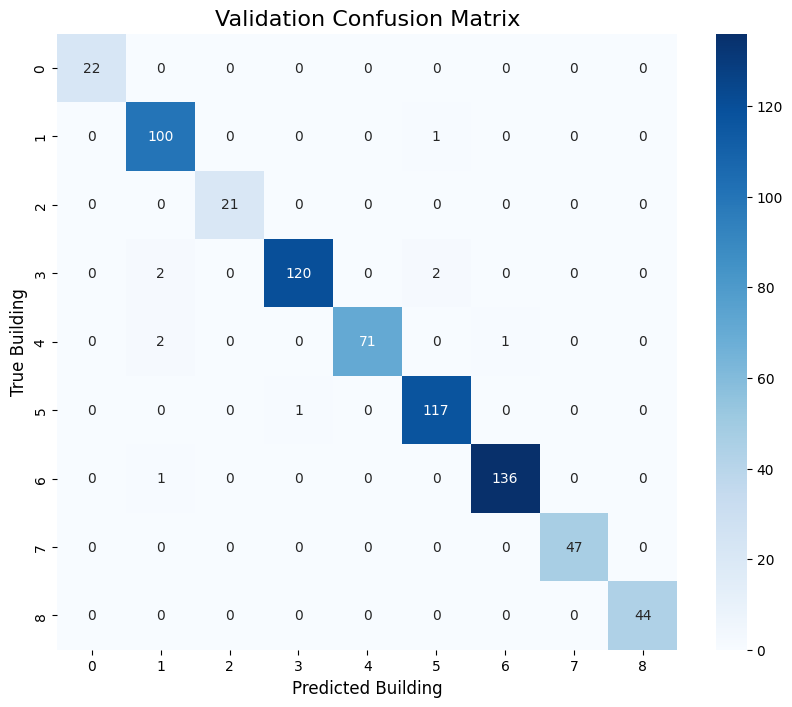

In [22]:
# confusion matrix on validation dataset
y_true = []
y_pred = []

for images, labels in val_ds:
    batch_preds = model.predict(images, verbose=0)
    batch_pred_indices = np.argmax(batch_preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(batch_pred_indices)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix', fontsize=16)
plt.ylabel('True Building', fontsize=12)
plt.xlabel('Predicted Building', fontsize=12)
plt.show()

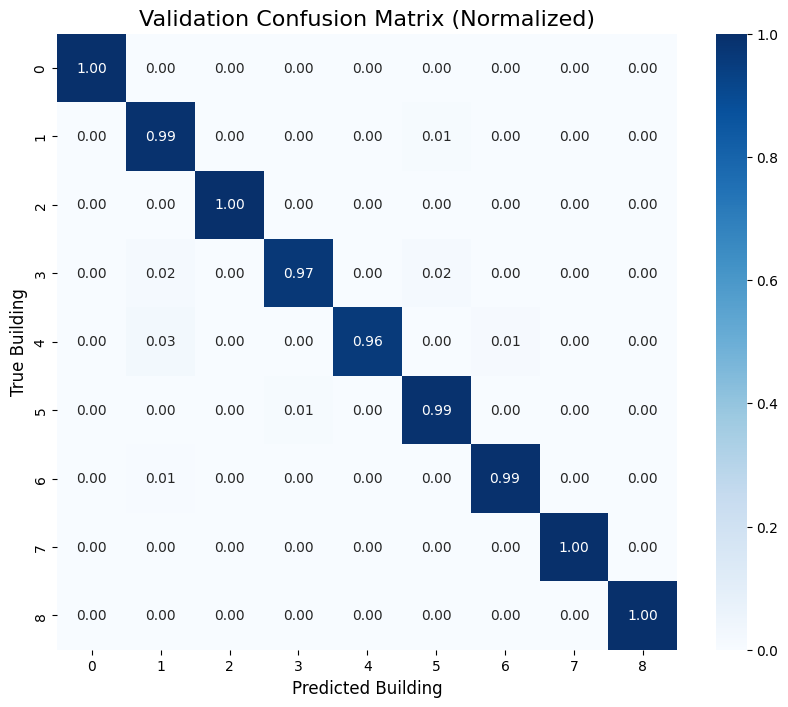

In [23]:
conf_matrix_ratio = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))

# confusion matrix with proportions
sns.heatmap(conf_matrix_ratio, annot=True, fmt='.2f', cmap='Blues')

plt.title('Validation Confusion Matrix (Normalized)', fontsize=16)
plt.ylabel('True Building', fontsize=12)
plt.xlabel('Predicted Building', fontsize=12)
plt.show()

In [25]:
# accuracy over validation 
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Validation Accuracy: {accuracy * 100:.2f}%")

Overall Validation Accuracy: 98.55%


# Analysis over sample of val_ds

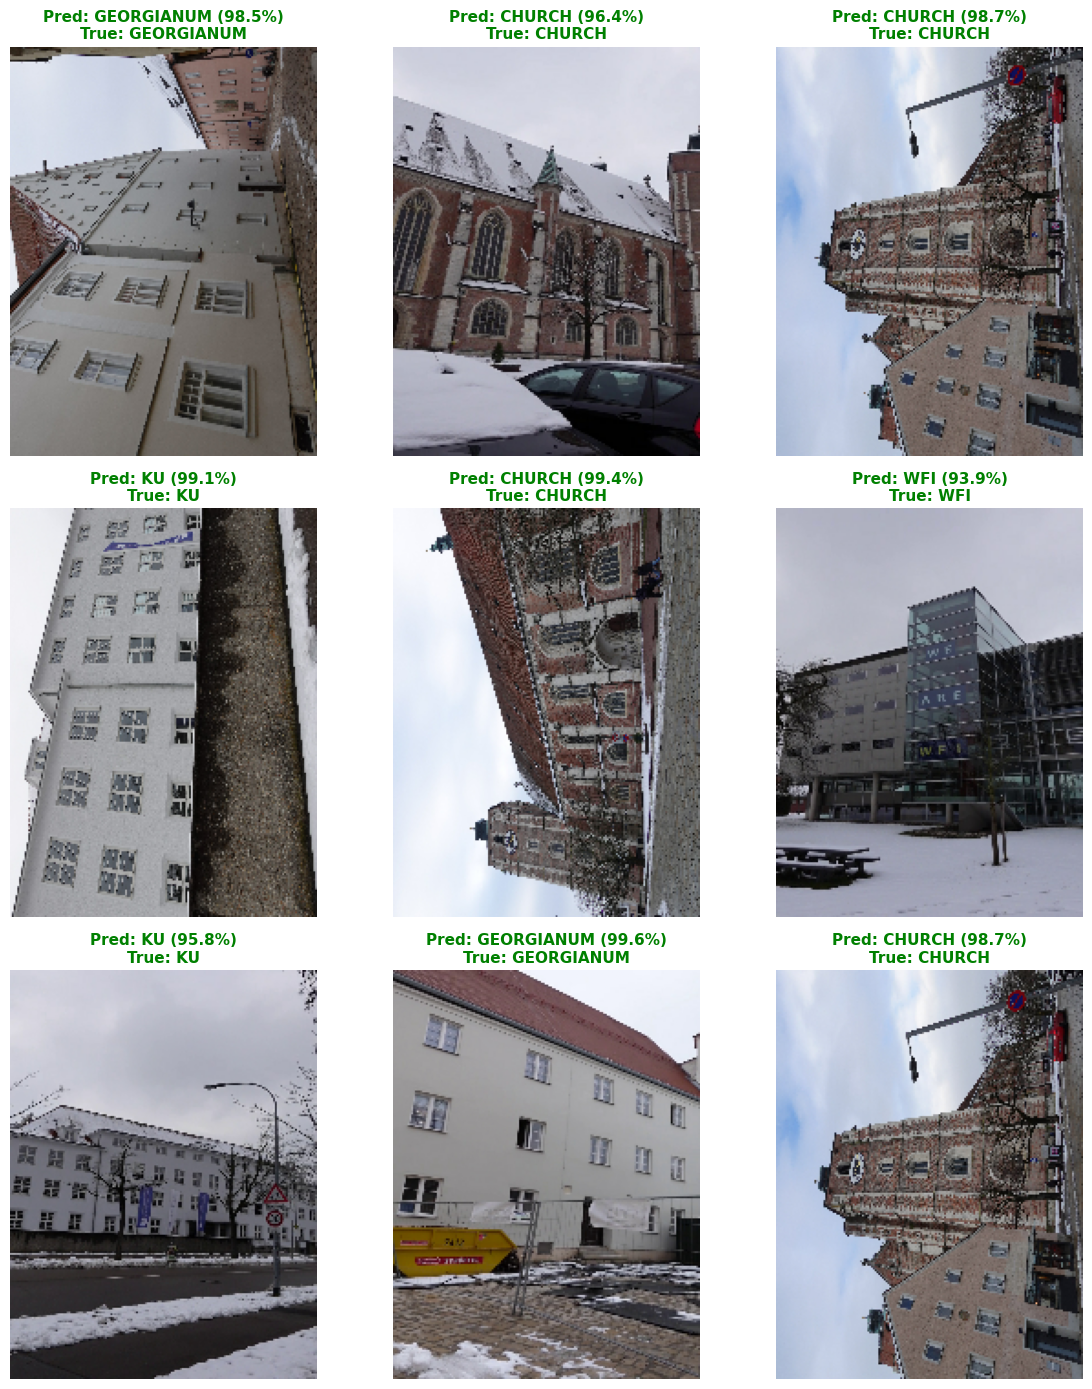

In [26]:
images, true_labels = next(iter(val_ds.take(1)))

# run the forward pass to get predictions
predictions = model.predict(images, verbose=0)
predicted_indices = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1) * 100

# set up the matplotlib figure
plt.figure(figsize=(12, 14))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis('off')
    
    # Extract the human-readable building names
    true_name = class_names[true_labels[i].numpy()]
    pred_name = class_names[predicted_indices[i]]
    conf = confidences[i]
    
    # Color-code the results for quick analysis
    title_color = 'green' if true_name == pred_name else 'red'
    
    # Add the text directly above the image
    plt.title(
        f"Pred: {pred_name.upper()} ({conf:.1f}%)\nTrue: {true_name.upper()}",
        color=title_color, fontsize=11, fontweight='bold'
    )

plt.tight_layout()
plt.show()